In [1]:
import sys 
sys.path.append('..')

from model.patch2self import patch2self

import numpy as np
np.random.RandomState(seed=2014)
import matplotlib.pyplot as plt

import dipy.data as dpd
import dipy.reconst.cross_validation as xval
import dipy.reconst.dti as dti
import dipy.reconst.csdeconv as csd
from dipy.reconst.shm import CsaOdfModel
import scipy.stats as stats
from dipy.io.image import load_nifti

- #### Load the dataset and denoise it with Patch2Self and Marchenko-Pastur
- #### Select the voxel locations in the Corpus Callosum (CC) and Centrum Semiovale (CSO)

In [2]:
dpd.fetch_stanford_hardi()
hardi_fname, hardi_bval_fname, hardi_bvec_fname = dpd.get_fnames('stanford_hardi')
img, gtab = dpd.read_stanford_hardi()
data, affine = load_nifti(hardi_fname)
data_p2s = patch2self(data, model='ridge') 
data_mppca, _ = load_nifti('dwi_mppca.nii') 

cc_vox = data[40, 70, 38]
cso_vox = data[30, 76, 38]

cc_vox_p2s = data_p2s[40, 70, 38]
cso_vox_p2s = data_p2s[30, 76, 38]

cc_vox_mp = data_mppca[40, 70, 38]
cso_vox_mp = data_mppca[30, 76, 38]

(160, 1, 652536)
Patch Extraction Done...
Training with patch-radius:  [0 0 0]
 -> Trained to Denoise Volume:  0
Denoising Volume  0  Complete...
 -> Trained to Denoise Volume:  1
Denoising Volume  1  Complete...
 -> Trained to Denoise Volume:  2
Denoising Volume  2  Complete...
 -> Trained to Denoise Volume:  3
Denoising Volume  3  Complete...
 -> Trained to Denoise Volume:  4
Denoising Volume  4  Complete...
 -> Trained to Denoise Volume:  5
Denoising Volume  5  Complete...
 -> Trained to Denoise Volume:  6
Denoising Volume  6  Complete...
 -> Trained to Denoise Volume:  7
Denoising Volume  7  Complete...
 -> Trained to Denoise Volume:  8
Denoising Volume  8  Complete...
 -> Trained to Denoise Volume:  9
Denoising Volume  9  Complete...
 -> Trained to Denoise Volume:  10
Denoising Volume  10  Complete...
 -> Trained to Denoise Volume:  11
Denoising Volume  11  Complete...
 -> Trained to Denoise Volume:  12
Denoising Volume  12  Complete...
 -> Trained to Denoise Volume:  13
Denoising

Denoising Volume  117  Complete...
 -> Trained to Denoise Volume:  118
Denoising Volume  118  Complete...
 -> Trained to Denoise Volume:  119
Denoising Volume  119  Complete...
 -> Trained to Denoise Volume:  120
Denoising Volume  120  Complete...
 -> Trained to Denoise Volume:  121
Denoising Volume  121  Complete...
 -> Trained to Denoise Volume:  122
Denoising Volume  122  Complete...
 -> Trained to Denoise Volume:  123
Denoising Volume  123  Complete...
 -> Trained to Denoise Volume:  124
Denoising Volume  124  Complete...
 -> Trained to Denoise Volume:  125
Denoising Volume  125  Complete...
 -> Trained to Denoise Volume:  126
Denoising Volume  126  Complete...
 -> Trained to Denoise Volume:  127
Denoising Volume  127  Complete...
 -> Trained to Denoise Volume:  128
Denoising Volume  128  Complete...
 -> Trained to Denoise Volume:  129
Denoising Volume  129  Complete...
 -> Trained to Denoise Volume:  130
Denoising Volume  130  Complete...
 -> Trained to Denoise Volume:  131
Denois

#### Initialize the DTI and CSD models

In [3]:
dti_model = dti.TensorModel(gtab)
response, ratio = csd.auto_response(gtab, data, 
                                    roi_radius=10, fa_thr=0.7)
csd_model = csd.ConstrainedSphericalDeconvModel(gtab, response)

dti_model = dti.TensorModel(gtab)
response_p2s, ratio = csd.auto_response(gtab, data_p2s, 
                                        roi_radius=10, fa_thr=0.7)
csd_model = csd.ConstrainedSphericalDeconvModel(gtab, response)

dti_model = dti.TensorModel(gtab)
response_mp, ratio = csd.auto_response(gtab, data_mppca, 
                                       roi_radius=10, fa_thr=0.7)
csd_model = csd.ConstrainedSphericalDeconvModel(gtab, response)

#### Run 3-Fold Crossvalidation

In [4]:
dti_cc = xval.kfold_xval(dti_model, cc_vox, 3)
csd_cc = xval.kfold_xval(csd_model, cc_vox, 3, response)
dti_cso = xval.kfold_xval(dti_model, cso_vox, 3)
csd_cso = xval.kfold_xval(csd_model, cso_vox, 3, response)

dti_cc_P2S = xval.kfold_xval(dti_model, cc_vox_p2s, 3)
csd_cc_P2S = xval.kfold_xval(csd_model, cc_vox_p2s, 3, response_p2s)
dti_cso_P2S = xval.kfold_xval(dti_model, cso_vox_p2s, 3)
csd_cso_P2S = xval.kfold_xval(csd_model, cso_vox_p2s, 3, response_p2s)

dti_cc_MP = xval.kfold_xval(dti_model, cc_vox_mp, 3)
csd_cc_MP = xval.kfold_xval(csd_model, cc_vox_mp, 3, response_mp)
dti_cso_MP = xval.kfold_xval(dti_model, cso_vox_mp, 3)
csd_cso_MP = xval.kfold_xval(csd_model, cso_vox_mp, 3, response_mp)

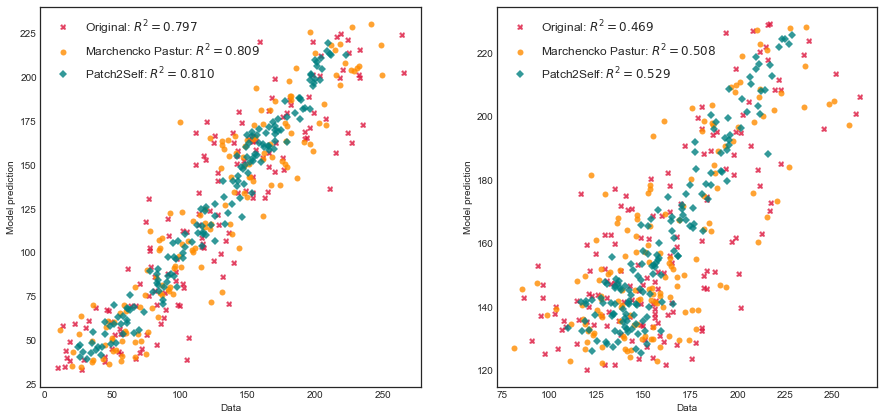

In [5]:
%matplotlib inline

plt.style.use('seaborn-white')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches([15, 7])
ax[0].plot(cc_vox[~gtab.b0s_mask], dti_cc[~gtab.b0s_mask], 
           'X', color='crimson', label='Original: $R^{2}=0.797$', alpha=0.8, markeredgewidth=0.0, fillstyle='full')
ax[0].plot(cc_vox_mp[~gtab.b0s_mask], dti_cc_MP[~gtab.b0s_mask], 
           'o', color='darkorange', label='Marchencko Pastur: $R^{2}=0.809$', alpha=0.8, markeredgewidth=0.0, fillstyle='full')
ax[0].plot(cc_vox_p2s[~gtab.b0s_mask], dti_cc_P2S[~gtab.b0s_mask], 
           'D', color='teal', label='Patch2Self: $R^{2}=0.810$', alpha=0.8, markeredgewidth=0.0, fillstyle='full')

ax[1].plot(cso_vox[~gtab.b0s_mask], dti_cso[~gtab.b0s_mask], 
           'X', color='crimson', label='Original: $R^{2}=0.469$', alpha=0.8, markeredgewidth=0.0, fillstyle='full')
ax[1].plot(cso_vox_mp[~gtab.b0s_mask], dti_cso_MP[~gtab.b0s_mask], 
           'o', color='darkorange', label='Marchencko Pastur: $R^{2}=0.508$', alpha=0.8, markeredgewidth=0.0, fillstyle='full')
ax[1].plot(cso_vox_p2s[~gtab.b0s_mask], dti_cso_P2S[~gtab.b0s_mask], 
           'D', color='teal', label='Patch2Self: $R^{2}=0.529$', alpha=0.8, markeredgewidth=0.0, fillstyle='full')

for this_ax in ax:
    this_ax.set_xlabel('Data')
    this_ax.set_ylabel('Model prediction')
    this_ax.legend(loc='upper left', fontsize='large')
fig.savefig("model_predictions_DTI.png.")

#### Compute $\mathbf{R}^2$ for each voxel  with the DTI model

In [6]:
cc_dti_r2 = stats.pearsonr(cc_vox[~gtab.b0s_mask], 
                           dti_cc[~gtab.b0s_mask])[0]**2
cc_dti_r2_mp = stats.pearsonr(cc_vox[~gtab.b0s_mask], 
                              dti_cc_MP[~gtab.b0s_mask])[0]**2
cc_dti_r2_p2s = stats.pearsonr(cc_vox[~gtab.b0s_mask], 
                               dti_cc_P2S[~gtab.b0s_mask])[0]**2

cso_dti_r2 = stats.pearsonr(cso_vox[~gtab.b0s_mask], 
                            dti_cso[~gtab.b0s_mask])[0]**2
cso_dti_r2_mp = stats.pearsonr(cso_vox[~gtab.b0s_mask], 
                               dti_cso_MP[~gtab.b0s_mask])[0]**2
cso_dti_r2_p2s = stats.pearsonr(cso_vox[~gtab.b0s_mask], 
                                dti_cso_P2S[~gtab.b0s_mask])[0]**2

print("Corpus callosum\n"
      "DTI Raw R2 : %s\n"
      "DTI MP-PCA R2 : %s\n"
      "DTI P2S R2 : %s\n"
      "\n"
      "Centrum Semiovale\n"
      "DTI Raw R2 : %s\n"
      "DTI MP-PCA R2 : %s\n"
      "DTI P2S R2 : %s\n" % (cc_dti_r2, 
                             cc_dti_r2_mp, 
                             cc_dti_r2_p2s, 
                             cso_dti_r2, 
                             cso_dti_r2_mp, 
                             cso_dti_r2_p2s))

Corpus callosum
DTI Raw R2 : 0.799386613530265
DTI MP-PCA R2 : 0.8023934243796694
DTI P2S R2 : 0.8112701578510251

Centrum Semiovale
DTI Raw R2 : 0.5038433583150319
DTI MP-PCA R2 : 0.501516492686054
DTI P2S R2 : 0.5279911876857333



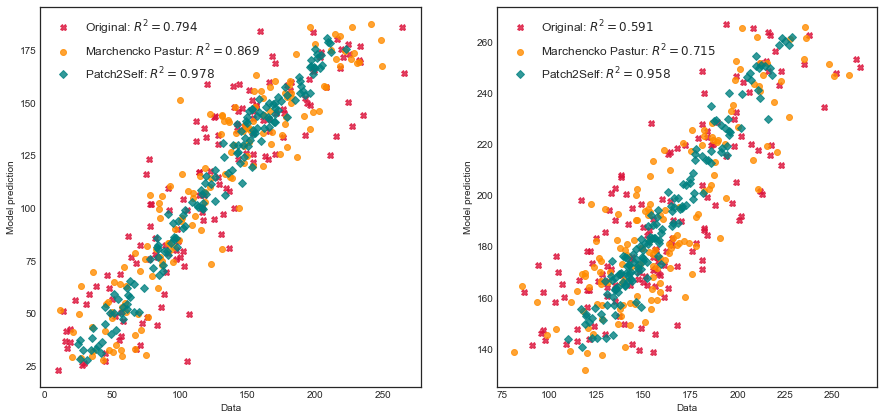

In [7]:
%matplotlib inline
plt.style.use('seaborn-white')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches([15, 7])
ax[0].plot(cc_vox[~gtab.b0s_mask], csd_cc[~gtab.b0s_mask], 
           'X', color='crimson', label='Original: $R^{2}=0.794$', alpha=0.8)
ax[0].plot(cc_vox_mp[~gtab.b0s_mask], csd_cc_MP[~gtab.b0s_mask], 
           'o', color='darkorange', label='Marchencko Pastur: $R^{2}=0.869$', alpha=0.8)
ax[0].plot(cc_vox_p2s[~gtab.b0s_mask], csd_cc_P2S[~gtab.b0s_mask], 
           'D', color='teal', label='Patch2Self: $R^{2}=0.978$', alpha=0.8)

ax[1].plot(cso_vox[~gtab.b0s_mask], csd_cso[~gtab.b0s_mask], 
           'X', color='crimson', label='Original: $R^{2}=0.591$', alpha=0.8)
ax[1].plot(cso_vox_mp[~gtab.b0s_mask], csd_cso_MP[~gtab.b0s_mask], 
           'o', color='darkorange', label='Marchencko Pastur: $R^{2}=0.715$', alpha=0.8)
ax[1].plot(cso_vox_p2s[~gtab.b0s_mask], csd_cso_P2S[~gtab.b0s_mask], 
           'D', color='teal', label='Patch2Self: $R^{2}=0.958$', alpha=0.8)

for this_ax in ax:
    this_ax.set_xlabel('Data')
    this_ax.set_ylabel('Model prediction')
    this_ax.legend(loc='upper left', fontsize='large')
fig.savefig("model_predictions.png")

In [ ]:
#### Compute $\mathbf{R}^2$ for each voxel  with the DTI model

In [8]:
cc_csd_r2 = stats.pearsonr(cc_vox[~gtab.b0s_mask], 
                           csd_cc[~gtab.b0s_mask])[0]**2
cc_csd_r2_mp = stats.pearsonr(cc_vox_mp[~gtab.b0s_mask], 
                              csd_cc_MP[~gtab.b0s_mask])[0]**2
cc_csd_r2_p2s = stats.pearsonr(cc_vox_p2s[~gtab.b0s_mask], 
                               csd_cc_P2S[~gtab.b0s_mask])[0]**2

cso_csd_r2 = stats.pearsonr(cso_vox[~gtab.b0s_mask], 
                            csd_cso[~gtab.b0s_mask])[0]**2
cso_csd_r2_mp = stats.pearsonr(cso_vox_mp[~gtab.b0s_mask], 
                               csd_cso_MP[~gtab.b0s_mask])[0]**2
cso_csd_r2_p2s = stats.pearsonr(cso_vox_p2s[~gtab.b0s_mask], 
                                csd_cso_P2S[~gtab.b0s_mask])[0]**2

print("Corpus callosum\n"
      "Original R-Squared: %s\n"
      "Marchenko-Pastur R-Squared: %s\n"
      "Patch2Self R-Squared: %s\n"
      "\n"
      "Centrum Semiovale\n"
      "Original R-Squared: %s\n"
      "Marchenko-Pastur R-Squared: %s\n"
      "Patch2Self R-Squared: %s\n" % (cc_csd_r2, 
                             cc_csd_r2_mp,
                             cc_csd_r2_p2s, 
                             cso_csd_r2, 
                             cso_csd_r2_mp, 
                             cso_csd_r2_p2s))

Corpus callosum
Original R-Squared: 0.7836926295772647
Marchenko-Pastur R-Squared: 0.8597981631711089
Patch2Self R-Squared: 0.9766926169507287

Centrum Semiovale
Original R-Squared: 0.6214990361088389
Marchenko-Pastur R-Squared: 0.7288195635860747
Patch2Self R-Squared: 0.9560768859316392

